# Ước lượng hiệu ứng can thiệp bằng phương pháp DML

### BS. Lê Ngọc Khả Nhi


# Nhập đề:

Bài thực hành này nhằm mục đích trình diễn phương pháp DML (Double Machine learning) để ước lượng hiệu quả can thiệp trung bình có điều kiện (CATE-DML : Conditional average treatment effect) thông qua thư viện EconML của Microsoft.

Thư viện EconML thuộc dự án ALICE (Automated Learning and Intelligence for Causation and Economics), với mục tiêu ứng dụng những kỹ thuật Machine learning tân tiến để giải quyết bài toán suy luận nhân quả trong kinh tế lượng (dĩ nhiên cũng là cholĩnh vực khác). 

Phương pháp DML có nguyên lý như sau: Từ một hệ thống gồm 4 nhân tố: Treatment T, Outcome Y, Hiệp biến X và Confounders W; lần lượt dựng 2 mô hình Machine learning A, B để : Ước lượng Y và Ước lượng propensity score (hay T), sau cùng dựng một mô hình Machine learning thứ 3 là C để ước lượng hiệu ứng can thiệp trung bình CATE.

Người dùng có thể dùng bất cứ algorithm Machine learning nào cho mô hình A và B, bao gồm mọi mô hình Regressor và Classifier trong thư viện scikitlearn hoặc XGboost, tùy bản chất của T và Y là biến nhị phân hay liên tục.

In [111]:
import warnings
warnings.filterwarnings('ignore')

# Module trợ giúp

import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Machine learning

from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Module chính

import econml
from econml.dml import DMLCateEstimator, LinearDMLCateEstimator,SparseLinearDMLCateEstimator  

from econml.dml import ForestDMLCateEstimator

Trong bài này, Nhi sẽ mô phỏng một hệ thống dữ liệu phức tạp, đa chiều với cấu trúc:

W là tập hợp có n_w counfounders, W ảnh hưởng đến propensity score (giá trị T) và chỉ tác động lên Outcome trong nhóm Control, nhưng W không góp phần vào hiệu quả trong nhóm can thiệp
    
X là 1 hiệp biến và X thực sự đóng góp vào hiệu quả can thiệp, thông qua 1 hàm mũ âm
    
T là 1 can thiệp, liên tục; propensity score của T liên hệ tuyến tính với W
    
Y là 1 biến kết cục (Outcome), liên tục

# Bước1: Mô phỏng dữ liệu cho thí nghiệm

In [167]:
def exp_te(x):
        return np.exp(-1.8*x[0])

def simulate_data(n = 3000, n_w = 30, support_size = 5, n_x = 1):
    
    def exp_te(x):
        return np.exp(-1.8*x[0])
    
    """
    Hàm này mô phỏng dữ liệu cho một thí nghiệm can thiệp phức tạp 
    
    Arguments:
    n = cỡ mẫu
    n_w = số confounders
    support_size = số lượng counfouders liên hệ với Outcome Y và propensity score của T
    
    Outputs:
    
    W là tập hợp có n_w counfounders, 
    Ghi chú: W ảnh hưởng đến propensity score và chỉ tác động lên Outcome trong nhóm Control,
    nhưng W không góp phần vào hiệu quả trong nhóm can thiệp
    
    X là 1 hiệp biến (thực sự đóng góp vào hiệu quả can thiệp, thông qua 1 hàm mũ âm)
    Y = f(X)
    
    T là 1 can thiệp, liên tục; propensity score của T liên hệ tuyến tính với W
    T = f(W)
    
    Y là 1 biến kết cục (Outcome), liên tục
    Y = f(T,W)
    """
    
    # Quy luật của kết cục Y
    
    support_Y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    epsilon_sample = lambda n: np.random.normal(0, 0.3, size=n)
    
    # Quy luật phân nhóm can thiệp
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=support_size)
    eta_sample = lambda n: np.random.normal(0, 0.3, size=n)
    
    # Mô phỏng hiệu ứng Control X và Hiệp biến X
    W = np.random.gamma(0.5, 1, size=(n, n_w))
    X = np.random.gamma(1, 1.4, size=(n, n_x))
    
    # Mô phỏng hiệu ứng can thiệp TE
    TE = np.array([exp_te(x_i) for x_i in X])
    
    # Mô phỏng Giá trị can thiệp T
    T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
    
    # Mô phỏng giá trị Outcome Y
    Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    
    # Sinh dữ liệu cho tập huấn luyện(70%), kiểm định (30%)
    Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(Y, T, X, W, test_size=0.3)
    X_test = np.array(list(product(np.arange(0, 3, 0.001), repeat=n_x)))

    return Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val, X_test

In [168]:
Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val, X_test = simulate_data(n = 3000, n_w = 30, support_size = 5, n_x = 1)

Cần chú ý rằng bản thân module econML không có khả năng tự phân tích được sơ đồ nhân quả như dowhy; mà người dùng phải tự đặt ra giả thuyết và xác định được đâu là W, đâu là X trong vấn đề của mình, thí nghiệm mô phỏng trong bài này có thể biểu diễn bằng sơ đồ nhân quả như sau:

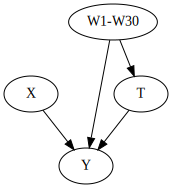

In [197]:
from causalgraphicalmodels import CausalGraphicalModel

model_obs = CausalGraphicalModel(
    nodes=["T", "Y", "X","W1-W30"],
    edges=[("T", "Y"), 
           ("X", "Y"), 
           ("W1-W30", "Y"),
           ("W1-W30", "T"), ])

model_obs.draw()

Mục tiêu của chúng ta là ước tính được hiệu quả can thiệp trung bình của T lên Y sau khi điều kiện hóa (hiệu chỉnh) theo W và X

Đây là hình dạng phân bố của 30 counfouders trong tập huấn luyện của W 

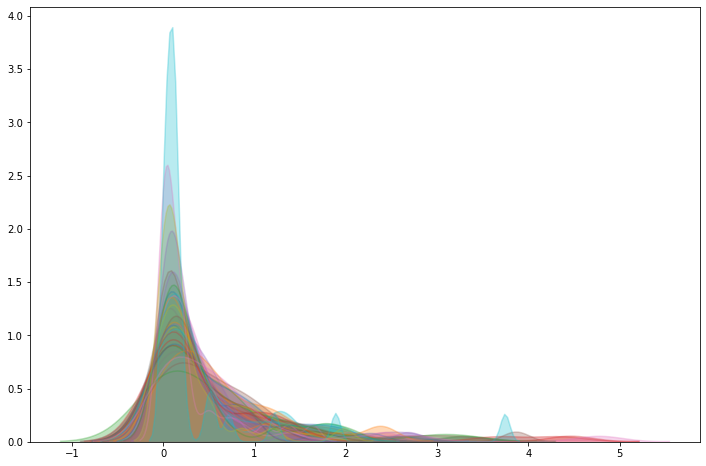

In [176]:
plt.figure(figsize=(12,8))

for i in range(30):
    sns.kdeplot(W_train[i], shade = True, alpha = 0.3)

Đây là hình dạng phân bố của hiệp biến X

Text(0.5, 0, 'Hiệp biến X')

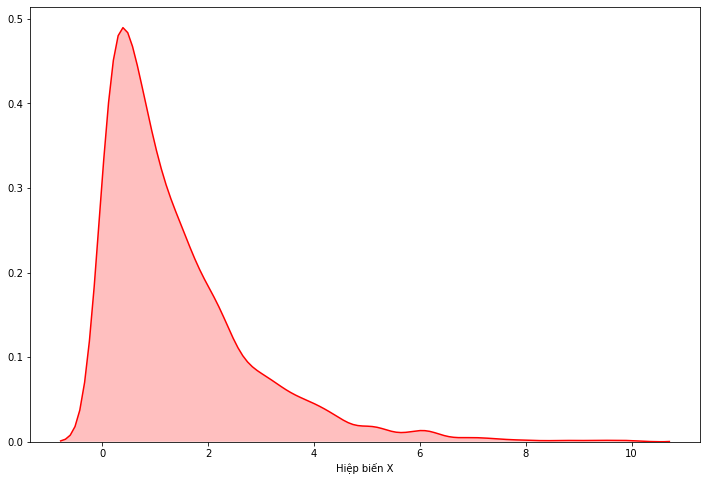

In [199]:
plt.figure(figsize=(12,8))

sns.kdeplot(X_train.reshape(X_train.shape[0]), shade = True, color = "red")
plt.xlabel('Hiệp biến X')

Phân bố của Y

Text(0.5, 0, 'Kết cục Y')

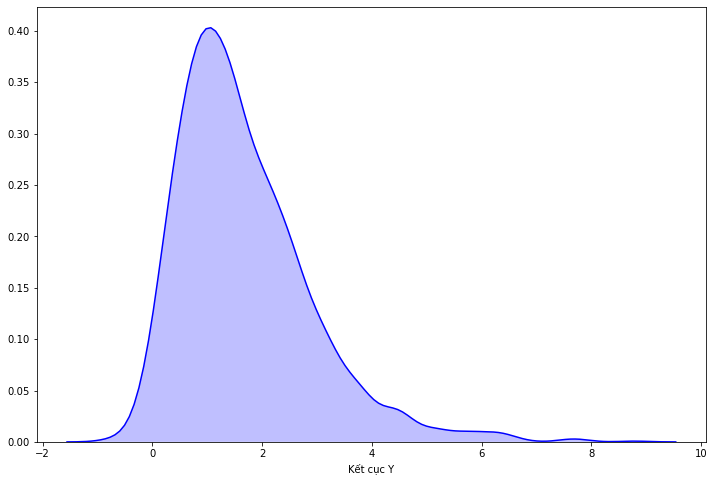

In [192]:
plt.figure(figsize=(12,8))

sns.kdeplot(Y_train.reshape(Y_train.shape[0]), shade = True, color = "blue")
plt.xlabel('Kết cục Y')

Phân bố của T

Text(0.5, 0, 'Can thiệp T')

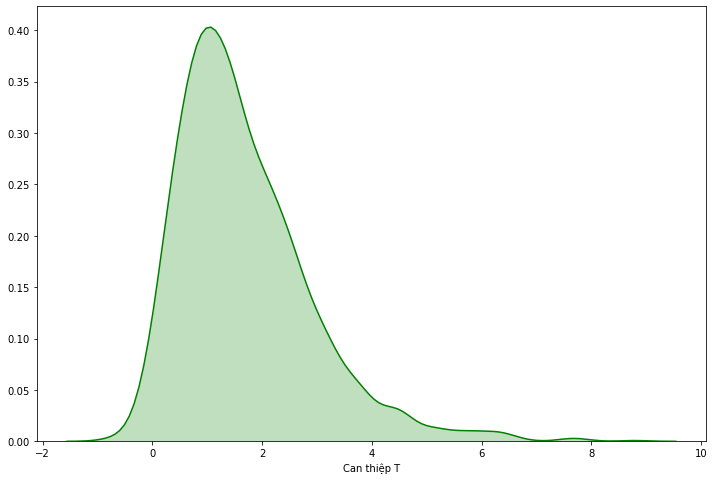

In [200]:
plt.figure(figsize=(12,8))

sns.kdeplot(Y_train.reshape(T_train.shape[0]), shade = True, color = "green")
plt.xlabel('Can thiệp T')

Đây là hình dạng phân phối xác suất kết hợp giữa Outcome Y (trục tung) và Can thiệp T (Trục hoành)

Text(0.5, 0, 'Can thiệp T')

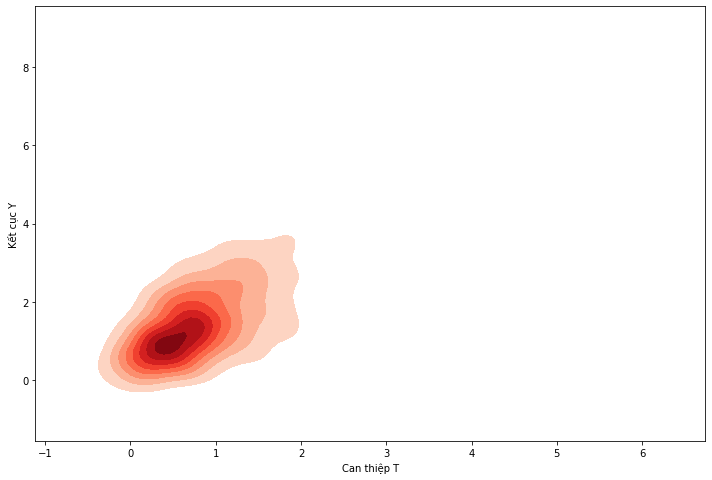

In [191]:
plt.figure(figsize=(12,8))

sns.kdeplot(T_train.reshape(T_train.shape[0]),
            Y_train.reshape(Y_train.shape[0]),
           cmap ="Reds", shade = True, 
            shade_lowest=False)

plt.ylabel('Kết cục Y')
plt.xlabel('Can thiệp T')

Đây là hình dạng phân phối xác suất kết hợp giữa Outcome Y (trục tung) và Hiệp biến X (Trục hoành)

Text(0.5, 0, 'Hiệp biến X')

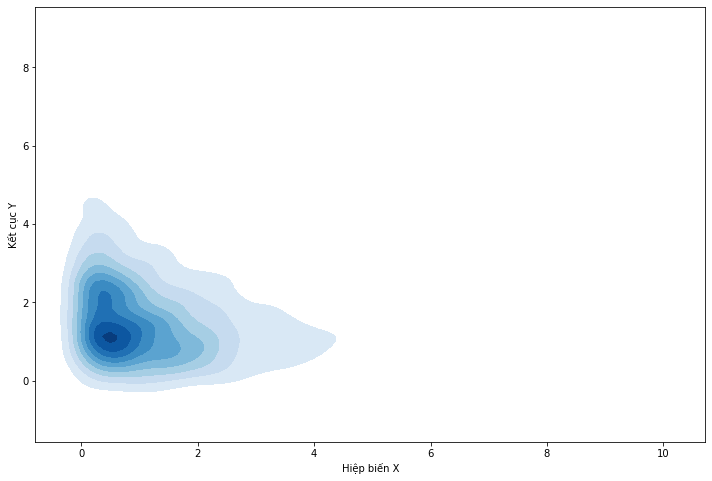

In [195]:
plt.figure(figsize=(12,8))

sns.kdeplot(X_train.reshape(X_train.shape[0]),
            Y_train.reshape(Y_train.shape[0]),
           cmap ="Blues", shade = True, 
            shade_lowest=False)

plt.ylabel('Kết cục Y')
plt.xlabel('Hiệp biến X')

Đây là hình dạng phân phối xác suất kết hợp giữa Can thiệp T (trục tung) và Hiệp biến X (Trục hoành)

Text(0.5, 0, 'Hiệp biến X')

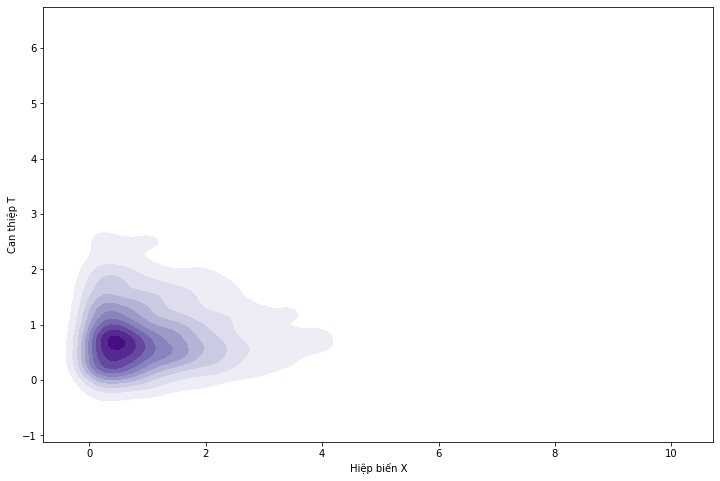

In [196]:
plt.figure(figsize=(12,8))

sns.kdeplot(X_train.reshape(X_train.shape[0]),
            T_train.reshape(T_train.shape[0]),
           cmap ="Purples", shade = True, 
            shade_lowest=False)

plt.ylabel('Can thiệp T')
plt.xlabel('Hiệp biến X')

# Bước 2: Huấn luyện mô hình

Ta sử dụng 2 mô hình XGBoost regressor để tiên lượng Y và T, mô hình DMLCATE estimator sử dụng algorithm Random Forest,
Với tùy chỉnh inference = bootstrap, mô hình sau cùng có khả năng xuất ra khoảng tin cậy:

In [157]:
xgb = XGBRegressor(max_depth = 5, learning_rate=0.01, 
                   n_estimators = 500, 
                   verbosity = 0, 
                   booster='gbtree', n_jobs = -1)

In [158]:
est = ForestDMLCateEstimator(model_y=xgb,
                              model_t=xgb,
                              discrete_treatment=False,
                              n_estimators=1000,
                              subsample_fr=0.8,
                              min_samples_leaf=10,
                              min_impurity_decrease=0.001,
                              verbose=0,
                              min_weight_fraction_leaf=.01)

est.fit(Y_train, T_train, X_train, W_train, inference = 'bootstrap')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.4min finished


Sau khi đã có mô hình, ta có thể khảo sát quy luật của CATE với input giả định trong khoảng 0:3

In [169]:
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished


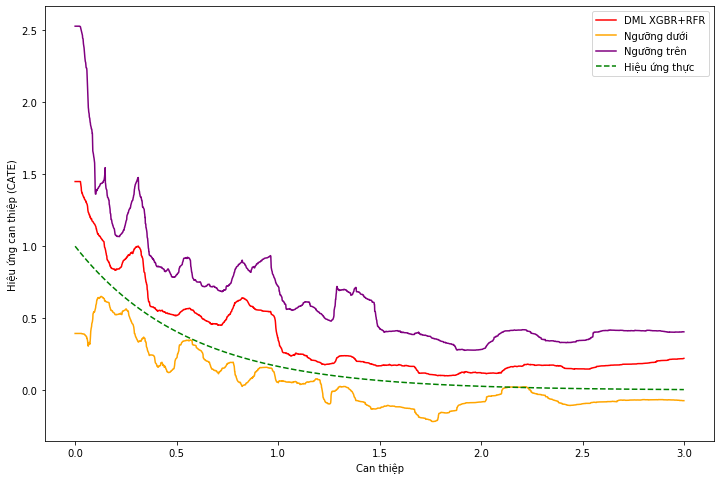

In [202]:
# Performance Visualization

plt.figure(figsize=(12,8))

plt.plot(X_test, te_pred, 'r-', label='DML XGBR+RFR')

plt.plot(X_test, lb, 'orange', label='Ngưỡng dưới')

plt.plot(X_test, ub, 'purple', label='Ngưỡng trên')

expected_te = np.array([exp_te(x_i) for x_i in X_test])

plt.plot(X_test, expected_te, 'g--', label='Hiệu ứng thực')

plt.ylabel('Hiệu ứng can thiệp (CATE)')
plt.xlabel('Can thiệp')

plt.legend()

plt.show()

# Kết luận

DML là một phương pháp thú vị để giải quyết bài toán ước lượng hiệu ứng can thiệp, ưu thế lớn nhất của phương pháp này đó là cho phép xử lý được dữ liệu phức tạp gồm rất nhiều confounders, cho phép xác định được các quy luật nhân quả phi tuyến tính mà mô hình SEM cổ điển và các mô hình tuyến tính không thể làm được. Tuy nhiên, hạn chế của package EconML đó là nó hoàn toàn máy móc, bản thân nó không kiểm chứng được sơ đồ nhân quả (Causal diagram, DAG), người dùng phải đặt ra một giả thuyết vững chắc trước khi thi hành DML, và phải nắm rõ vai trò của từng bộ phận bên trong hệ thống giả thuyết này.